In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import tensorflow.keras.layers as ly
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
import itertools

train_b = True

#LSTM_VAR = 400;EPOCH_VAR = 10
# LSTM_VAR = 100;EPOCH_VAR = 10
# LSTM_VAR = 500;EPOCH_VAR = 5
# LSTM_VAR = 1000;EPOCH_VAR = 5
# LSTM_VAR = 100;EPOCH_VAR = 5
# LSTM_VAR = 100;EPOCH_VAR = 20
# LSTM_VAR = 1000;EPOCH_VAR = 5

# LSTM_VAR = 100;EPOCH_VAR = 10;dropout_var=0.0
# #LSTM_VAR = 500;EPOCH_VAR = 5

# model_name = 'test_model_slope_with_solar_weather_future_100_HWC_e10.h5'
# model_name = f"best_model_timevar_e{EPOCH_VAR}_LSTM_{LSTM_VAR}.h5"
# model_name = f"best_model_timevar_no_weekend_e{EPOCH_VAR}_LSTM_{LSTM_VAR}_Dropout{dropout_var}.h5"
#model_name = f"best_model_timevar_no_weekend_no_dropout_e{EPOCH_VAR}_LSTM_{LSTM_VAR}.h5"

In [3]:
def RMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])*float(y_test[i]-y_pred[i]) for i in range(n)]
    return np.sqrt(sum(rmse_list)/float(n))
def RRMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])**2 for i in range(n)]
    n = [float(y_test[i])**2 for i in range(n)]
    return np.sqrt(sum(rmse_list)/sum(n))        
def RMSE_list(y_test,y_pred):
    y_test = list(y_test); 
    y_test = [list(ln) for ln in y_test]
    y_pred = list(y_pred); 
    y_pred = [list(ln) for ln in y_pred]
    n = len(y_test); m = len(y_test[0])
    rmse_list = [np.square(float(y_test[i][j]-y_pred[i][j])) for i in range(n) for j in range(m)]
    return np.sqrt(sum(rmse_list)/float(n))

#Load and Reshape Data

In [4]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Merged"
print(os.walk("/content/drive/MyDrive"))
hist_window=18;forecast_window=18
#hist_window=int(12*60/5)

<generator object _walk at 0x7fabe550f890>


In [5]:
data =  pd.read_csv(f"{DATA_DIR}/full_merge_v3.csv")

df_t = pd.to_datetime(data['Time Stamp'])
time= df_t.dt.hour.astype(str)+":"+df_t.dt.minute.astype(str)
data['uw_range']=0;data['ow_range']=0

uw = ['04:00','04:05','04:10','04:15','04:20','04:25',
      '04:30','04:35','04:40','04:45','04:50','04:55',
      '05:00','05:05','05:10','05:15','05:20','05:25',
      '05:30']

ow = ['06:15','06:20','06:25',
      '06:30','06:35','06:40','06:45','06:50','06:55',
      '07:00','07:05','07:10','07:15','07:20','07:25',
      '07:30','07:35','07:40','07:45',
      '16:30','16:35','16:40','16:45','16:50','16:55',
      '17:00','17:05','17:10','17:15','17:20','17:25','17:30']

data['uw_range'][time.isin(uw)] = 1
data['ow_range'][time.isin(ow)] = 1
data['ow_range'][time.isin(ow)] = 1
print(data.head(10).to_string())

future_var = ['Dni','HourlyDryBulbTemperature']
for c in future_var:
  data[c+" Future"] = data[c].shift(-forecast_window).backfill()

used_var = ['N.Y.C.','Dni','HourlyDryBulbTemperature','Dni Future','HourlyDryBulbTemperature Future','uw_range','ow_range']
data = data[used_var +['year']].backfill();
data = data.dropna(how='any')

for c in used_var:
  print(c,len(data[c].index),data[c].mean(),data[c].std())

print(data.head(5).to_string())
n = len(data.index)
t = int(365*24*(60/5))
num_var = len(used_var)

<ipython-input-5-87e64aa2f4e8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['uw_range'][time.isin(uw)] = 1
<ipython-input-5-87e64aa2f4e8>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ow_range'][time.isin(ow)] = 1
<ipython-input-5-87e64aa2f4e8>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ow_range'][time.isin(ow)] = 1


   Unnamed: 0           Time Stamp  CAPITL  CENTRL  DUNWOD  GENESE  HUD VL  LONGIL  MHK VL  MILLWD  N.Y.C.  NORTH    WEST     NYCA             datetime  year  month  day  hour  minute  dow_x             PeriodEnd           PeriodStart Period  AirTemp  Azimuth  CloudOpacity  DewpointTemp  Dhi  Dni  Ebh  Ghi  GtiFixedTilt  GtiTracking  PrecipitableWater  RelativeHumidity  SnowWater  SurfacePressure  WindDirection10m  WindSpeed10m  Zenith  AlbedoDaily  dow_y  HourlyDryBulbTemperature  HourlyRelativeHumidity  uw_range  ow_range
0           0  2017-01-01 00:00:00  1211.6  1671.9   620.2   978.6  1012.3  2161.0   867.2   320.6  5116.9  539.2  1635.2  16134.7  2017-01-01 00:00:00  2017      1    1     0       0      6  2017-01-01T05:00:00Z  2017-01-01T04:55:00Z   PT5M      6.8      1.0          76.4          -4.8  0.0  0.0  0.0  0.0           0.0          0.0               14.5              43.5        0.0           1011.9             226.0           7.0   162.0         0.12    6.0           

In [6]:
import datetime
import holidays
def get_national_holidays(start_date, end_date, country):
    # Get the Bank Holidays for the given country
    holiday_days = holidays.CountryHoliday(country)
    # Create a list of dates between the start and end date
    date_range = pd.date_range(start_date, end_date)
    # Filter the dates to only include Bank Holidays
    national_holidays = [str(date)[0:10] for date in date_range if date in holiday_days]
    return national_holidays

#Holiday Boolean
holidays = get_national_holidays(df_t.min(), df_t.max(), 'US')
data['Holiday_Weekend_B'] = df_t.astype(str).str[0:10].isin(holidays).map({True:1, False:0})
#Weekend Boolean (Weekends are 5&6)
data['Holiday_Weekend_B'][(df_t.dt.dayofweek).isin([5,6])]=1
data['Holiday_Weekend_B']=data['Holiday_Weekend_B'].shift(forecast_window).bfill().ffill()

data['uw_range'][(df_t.dt.dayofweek).isin([5,6])]=0
data['ow_range'][(df_t.dt.dayofweek).isin([5,6])]=0

#Print
used_var=used_var+['Holiday_Weekend_B']
num_var = len(used_var)

print(data[used_var].head(20).to_string())

<ipython-input-6-75a7ef157d5b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Holiday_Weekend_B'][(df_t.dt.dayofweek).isin([5,6])]=1
<ipython-input-6-75a7ef157d5b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['uw_range'][(df_t.dt.dayofweek).isin([5,6])]=0


    N.Y.C.  Dni  HourlyDryBulbTemperature  Dni Future  HourlyDryBulbTemperature Future  uw_range  ow_range  Holiday_Weekend_B
0   5116.9  0.0                 44.000000         0.0                        44.588235         0         0                1.0
1   5102.1  0.0                 44.000000         0.0                        44.686275         0         0                1.0
2   5074.9  0.0                 44.000000         0.0                        44.784314         0         0                1.0
3   5089.6  0.0                 44.000000         0.0                        44.882353         0         0                1.0
4   5061.3  0.0                 44.000000         0.0                        44.980392         0         0                1.0
5   5042.6  0.0                 44.000000         0.0                        44.933333         0         0                1.0
6   5011.6  0.0                 44.000000         0.0                        44.850000         0         0            

<ipython-input-6-75a7ef157d5b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ow_range'][(df_t.dt.dayofweek).isin([5,6])]=0


In [7]:
m = 5574.113154123897;std = 1157.6820234795014
m_s = 176.74872041098973 ;std_s = 310.4973536354869
m_t = 56.030910041113;std_t = 16.507268780702415
m_d = 0;std_d=1
#N.Y.C. 631062 5785.801098166661 1225.8381262919374
#Dni 631062 176.74872041098973 310.4973536354869
#HourlyDryBulbTemperature 631062 55.41743325211331 16.947708813988072

m_list = [m,m_s,m_t,m_s,m_t,m_d,m_d,m_d,m_d]
std_list = [std,std_s,std_t,std_s,std_t,std_d,std_d,std_d,std_d]

def untransform_dataset_old(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==3:
    ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    dataset=dataset.reshape(nv,ns*tw)
    dataset = np.array([(dataset[i]*stdi[i])+mi[i] for i in range(s[1])])
    dataset=dataset.reshape(s[0],s[1],s[2])
  else: 
    dataset=(dataset*stdi[0])+mi[0]
  return dataset

def create_dataset(dataset, hist_window=18,forecast_window=18):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(len(dataset)-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].reshape(-1); dataX.append(a)
    dataY.append(dataset[i + hist_window:  i + hist_window+forecast_window])
  return np.array(dataX), np.array(dataY)
def create_dataset_mult(dataset, hist_window=18,forecast_window=18,num_var=3):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(dataset.shape[0]-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].T
    dataX.append(a)
    
    e = dataset[i + hist_window:  i + hist_window+forecast_window, 0]
    dataY.append(e)
  return np.array(dataX), np.array(dataY)

def transform_dataset(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==2:
    #ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    ns,nv = s
    dataset=dataset.T 
    dataset = np.array([(dataset[i]-mi[i])/stdi[i] for i in range(s[1])])
    dataset=dataset.T 
  else:
    dataset=(dataset-mi[0])/stdi[0] 
  return dataset
def untransform_dataset(dataset,mi=m_list,stdi=std_list):
  dataset=(dataset*stdi[0])+mi[0]
  return dataset  
print(data[used_var])
dataset = data[used_var].values
dataset_xfr = transform_dataset(dataset)

x,y = create_dataset_mult(dataset_xfr,hist_window,forecast_window,num_var)
train,label_t = x[0:n-t],y[0:n-t]
valid,label_v = x[n-t:], y[n-t:]

           N.Y.C.  Dni  HourlyDryBulbTemperature  Dni Future  \
0       5116.9000  0.0                      44.0         0.0   
1       5102.1000  0.0                      44.0         0.0   
2       5074.9000  0.0                      44.0         0.0   
3       5089.6000  0.0                      44.0         0.0   
4       5061.3000  0.0                      44.0         0.0   
...           ...  ...                       ...         ...   
630985  4989.4395  0.0                      49.0         0.0   
630986  4943.5040  0.0                      49.0         0.0   
630987  4948.2573  0.0                      49.0         0.0   
630988  4927.0645  0.0                      49.0         0.0   
630989  4945.7383  0.0                      49.0         0.0   

        HourlyDryBulbTemperature Future  uw_range  ow_range  Holiday_Weekend_B  
0                             44.588235         0         0                1.0  
1                             44.686275         0         0          

In [8]:
ys = []
n_cutoff = []
for yr in range(2017, 2023):
  ys.append(yr)
  n_cutoff.append(data.year.isin(ys).sum())

train_set = []
val_set = []
for i in range(len(n_cutoff)-1):
  train,label_t = x[0:n_cutoff[i]],y[0:n_cutoff[i]]
  valid,label_v = x[n_cutoff[i]:n_cutoff[i+1]], y[n_cutoff[i]:n_cutoff[i+1]]
  train_set.append((train,label_t))
  val_set.append((valid,label_v))

In [9]:
# reshape input to be [samples, time steps, features]
#print(train.shape)
#train = np.reshape(train, (train.shape[0], num_var, train.shape[1]))
#valid = np.reshape(valid, (valid.shape[0], num_var, valid.shape[1]))

#Build Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               47600     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 18)                1818      
                                                                 
Total params: 59,518
Trainable params: 59,518
Non-trainable params: 0
_________________________________________________________________


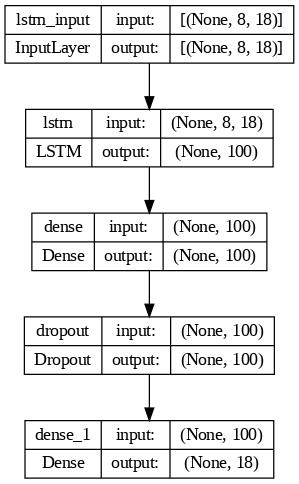

In [10]:
import datetime
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Saved_Model"
def create_LSTM_model(LSTM_i = 4, dropout=0.3, recurrent_dropout=0,
                      var_num = 8,
                      hist_window=18,forecast_window=18):

    model = Sequential()
    model.add(LSTM(LSTM_i, input_shape=(var_num,hist_window),recurrent_dropout = recurrent_dropout))
    model.add(Dense(100))
    model.add(Dropout(dropout))
    model.add(Dense(forecast_window))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_LSTM_model(LSTM_i=100, var_num=num_var)
model.summary()
plot_model(model, show_shapes=True, dpi=90)

In [11]:
def fit_and_evaluate(model, train, label_t, valid, label_v, epochs = 1):
  model.fit(train, label_t, epochs=epochs, verbose =2)
  label_p   = model.predict(valid)

  label_p = untransform_dataset(label_p)
  label_v = untransform_dataset(label_v)

  # calculate root mean squared error
  # print('Total Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

  for i,ln in enumerate(label_p):
    if i==0: 
      label_p_plot=list(label_p[0])
      label_v_plot=list(label_v[0])
    else:
      label_p_plot=label_p_plot+ [label_p[i][-1]]
      label_v_plot=label_v_plot+ [label_v[i][-1]]

  # print('90 Min Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))
  # print('Relative Test Score: %.2f perc RMSE' % (100*RRMSE(label_v_plot, label_p_plot)))
  rmse_l = RMSE_list(label_v, label_p)
  rmse = RMSE(label_v_plot, label_p_plot)
  rrmse = 100*RRMSE(label_v_plot, label_p_plot)
  return [rmse_l, rmse, rrmse]


param_grid = {'LSTM_i':[100, 250, 500],
 'recurrent_dropout':[0, 0.05,0.1],
 'dropout': [0,0.05,0.1]}

keys, values = zip(*param_grid.items())
experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [15]:
experiments[24]

{'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0}

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Cross Validation/result.csv', index_col=0)
test.iloc[-37:-2,].reset_index(drop = True).to_csv('/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Cross Validation/result2.csv')

In [15]:
exp = experiments[17]
res_dict = exp.copy()
i=4
print(f'checking fold {i+1}')
model = create_LSTM_model(**exp)
res = fit_and_evaluate(model, *train_set[i], *val_set[i], epochs = 10)
res_dict.update({'fold': i+1, 'rmse_l': res[0],'rmse':res[1], 'rrmse':res[2]})
print(res_dict)
pd.DataFrame([res_dict]).to_csv("/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Cross Validation/result2.csv", mode = 'a')


checking fold 5
Epoch 1/10
16434/16434 - 185s - loss: 0.0185 - 185s/epoch - 11ms/step
Epoch 2/10
16434/16434 - 177s - loss: 0.0063 - 177s/epoch - 11ms/step
Epoch 3/10
16434/16434 - 172s - loss: 0.0052 - 172s/epoch - 10ms/step
Epoch 4/10
16434/16434 - 173s - loss: 0.0048 - 173s/epoch - 11ms/step
Epoch 5/10
16434/16434 - 172s - loss: 0.0046 - 172s/epoch - 10ms/step
Epoch 6/10
16434/16434 - 172s - loss: 0.0044 - 172s/epoch - 10ms/step
Epoch 7/10
16434/16434 - 172s - loss: 0.0043 - 172s/epoch - 10ms/step
Epoch 8/10
16434/16434 - 171s - loss: 0.0042 - 171s/epoch - 10ms/step
Epoch 9/10
16434/16434 - 171s - loss: 0.0042 - 171s/epoch - 10ms/step
Epoch 10/10
16434/16434 - 172s - loss: 0.0041 - 172s/epoch - 10ms/step
3284/3284 [==============================] - 15s 4ms/step
{'LSTM_i': 250, 'recurrent_dropout': 0.1, 'dropout': 0.1, 'fold': 5, 'rmse_l': 240.32632535792234, 'rmse': 85.45256409143458, 'rrmse': 1.4732253741396373}


In [16]:


results = []
for exp in experiments[25:]: 
  print(f'exprimenting: {exp}')
  for i in range(len(train_set)):
    res_dict = exp.copy()
    print(f'checking fold {i+1}')
    model = create_LSTM_model(**exp)
    res = fit_and_evaluate(model, *train_set[i], *val_set[i], epochs = 10)
    res_dict.update({'fold': i+1, 'rmse_l': res[0],'rmse':res[1], 'rrmse':res[2]})
    print(res_dict)
    results.append(res_dict)
    pd.DataFrame([res_dict]).to_csv("/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Cross Validation/result2.csv", mode = 'a')

result = pd.DataFrame(results)
result.to_csv("/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Cross Validation/result3.csv")
result

exprimenting: {'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.05}
checking fold 1
Epoch 1/10
3285/3285 - 42s - loss: 0.0384 - 42s/epoch - 13ms/step
Epoch 2/10
3285/3285 - 38s - loss: 0.0115 - 38s/epoch - 12ms/step
Epoch 3/10
3285/3285 - 36s - loss: 0.0084 - 36s/epoch - 11ms/step
Epoch 4/10
3285/3285 - 37s - loss: 0.0066 - 37s/epoch - 11ms/step
Epoch 5/10
3285/3285 - 36s - loss: 0.0058 - 36s/epoch - 11ms/step
Epoch 6/10
3285/3285 - 37s - loss: 0.0054 - 37s/epoch - 11ms/step
Epoch 7/10
3285/3285 - 38s - loss: 0.0049 - 38s/epoch - 11ms/step
Epoch 8/10
3285/3285 - 36s - loss: 0.0046 - 36s/epoch - 11ms/step
Epoch 9/10
3285/3285 - 35s - loss: 0.0043 - 35s/epoch - 11ms/step
Epoch 10/10
3285/3285 - 36s - loss: 0.0041 - 36s/epoch - 11ms/step
3285/3285 [==============================] - 16s 5ms/step
{'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.05, 'fold': 1, 'rmse_l': 271.5549312375014, 'rmse': 97.37190723461617, 'rrmse': 1.5633692533575245}


checking fold 2
Epoch 1/10
6570/6570 - 74s - loss: 0.0270 - 74s/epoch - 11ms/step
Epoch 2/10
6570/6570 - 74s - loss: 0.0079 - 74s/epoch - 11ms/step
Epoch 3/10
6570/6570 - 69s - loss: 0.0059 - 69s/epoch - 11ms/step
Epoch 4/10
6570/6570 - 69s - loss: 0.0050 - 69s/epoch - 11ms/step
Epoch 5/10
6570/6570 - 69s - loss: 0.0045 - 69s/epoch - 10ms/step
Epoch 6/10
6570/6570 - 69s - loss: 0.0042 - 69s/epoch - 11ms/step
Epoch 7/10
6570/6570 - 69s - loss: 0.0039 - 69s/epoch - 11ms/step
Epoch 8/10
6570/6570 - 69s - loss: 0.0038 - 69s/epoch - 10ms/step
Epoch 9/10
6570/6570 - 70s - loss: 0.0036 - 70s/epoch - 11ms/step
Epoch 10/10
6570/6570 - 72s - loss: 0.0035 - 72s/epoch - 11ms/step
3285/3285 [==============================] - 16s 5ms/step


{'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.05, 'fold': 2, 'rmse_l': 258.39103665916855, 'rmse': 86.71651214631375, 'rrmse': 1.430825586264582}
checking fold 3
Epoch 1/10
9855/9855 - 108s - loss: 0.0194 - 108s/epoch - 11ms/step
Epoch 2/10
9855/9855 - 105s - loss: 0.0061 - 105s/epoch - 11ms/step
Epoch 3/10
9855/9855 - 106s - loss: 0.0047 - 106s/epoch - 11ms/step
Epoch 4/10
9855/9855 - 107s - loss: 0.0041 - 107s/epoch - 11ms/step
Epoch 5/10
9855/9855 - 105s - loss: 0.0038 - 105s/epoch - 11ms/step
Epoch 6/10
9855/9855 - 105s - loss: 0.0035 - 105s/epoch - 11ms/step
Epoch 7/10
9855/9855 - 104s - loss: 0.0034 - 104s/epoch - 11ms/step
Epoch 8/10
9855/9855 - 106s - loss: 0.0033 - 106s/epoch - 11ms/step
Epoch 9/10
9855/9855 - 105s - loss: 0.0032 - 105s/epoch - 11ms/step
Epoch 10/10
9855/9855 - 104s - loss: 0.0032 - 104s/epoch - 11ms/step
3294/3294 [==============================] - 17s 5ms/step


{'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.05, 'fold': 3, 'rmse_l': 447.04967091492074, 'rmse': 177.43891673068396, 'rrmse': 3.1722700369569727}
checking fold 4
Epoch 1/10
13149/13149 - 141s - loss: 0.0181 - 141s/epoch - 11ms/step
Epoch 2/10
13149/13149 - 141s - loss: 0.0057 - 141s/epoch - 11ms/step
Epoch 3/10
13149/13149 - 139s - loss: 0.0044 - 139s/epoch - 11ms/step
Epoch 4/10
13149/13149 - 139s - loss: 0.0040 - 139s/epoch - 11ms/step
Epoch 5/10
13149/13149 - 138s - loss: 0.0037 - 138s/epoch - 11ms/step
Epoch 6/10
13149/13149 - 137s - loss: 0.0035 - 137s/epoch - 10ms/step
Epoch 7/10
13149/13149 - 139s - loss: 0.0033 - 139s/epoch - 11ms/step
Epoch 8/10
13149/13149 - 153s - loss: 0.0033 - 153s/epoch - 12ms/step
Epoch 9/10
13149/13149 - 153s - loss: 0.0032 - 153s/epoch - 12ms/step
Epoch 10/10
13149/13149 - 148s - loss: 0.0031 - 148s/epoch - 11ms/step
3285/3285 [==============================] - 17s 5ms/step


{'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.05, 'fold': 4, 'rmse_l': 253.86318108659665, 'rmse': 92.37730460950102, 'rrmse': 1.6226998622068525}
checking fold 5
Epoch 1/10
16434/16434 - 185s - loss: 0.0153 - 185s/epoch - 11ms/step
Epoch 2/10
16434/16434 - 180s - loss: 0.0053 - 180s/epoch - 11ms/step
Epoch 3/10
16434/16434 - 176s - loss: 0.0043 - 176s/epoch - 11ms/step
Epoch 4/10
16434/16434 - 177s - loss: 0.0038 - 177s/epoch - 11ms/step
Epoch 5/10
16434/16434 - 174s - loss: 0.0036 - 174s/epoch - 11ms/step
Epoch 6/10
16434/16434 - 174s - loss: 0.0034 - 174s/epoch - 11ms/step
Epoch 7/10
16434/16434 - 174s - loss: 0.0033 - 174s/epoch - 11ms/step
Epoch 8/10
16434/16434 - 174s - loss: 0.0032 - 174s/epoch - 11ms/step
Epoch 9/10
16434/16434 - 174s - loss: 0.0031 - 174s/epoch - 11ms/step
Epoch 10/10
16434/16434 - 174s - loss: 0.0031 - 174s/epoch - 11ms/step
3284/3284 [==============================] - 15s 4ms/step


{'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.05, 'fold': 5, 'rmse_l': 225.93959226657256, 'rmse': 81.55148289776156, 'rrmse': 1.4059696766400451}
exprimenting: {'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.1}
checking fold 1
Epoch 1/10
3285/3285 - 39s - loss: 0.0444 - 39s/epoch - 12ms/step
Epoch 2/10
3285/3285 - 35s - loss: 0.0122 - 35s/epoch - 11ms/step
Epoch 3/10
3285/3285 - 34s - loss: 0.0089 - 34s/epoch - 10ms/step
Epoch 4/10
3285/3285 - 36s - loss: 0.0074 - 36s/epoch - 11ms/step
Epoch 5/10
3285/3285 - 35s - loss: 0.0067 - 35s/epoch - 11ms/step
Epoch 6/10
3285/3285 - 36s - loss: 0.0060 - 36s/epoch - 11ms/step
Epoch 7/10
3285/3285 - 36s - loss: 0.0057 - 36s/epoch - 11ms/step
Epoch 8/10
3285/3285 - 36s - loss: 0.0053 - 36s/epoch - 11ms/step
Epoch 9/10
3285/3285 - 35s - loss: 0.0050 - 35s/epoch - 11ms/step
Epoch 10/10
3285/3285 - 36s - loss: 0.0049 - 36s/epoch - 11ms/step
3285/3285 [==============================] - 16s 5ms/step


{'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.1, 'fold': 1, 'rmse_l': 302.6542648585976, 'rmse': 108.71580583694104, 'rrmse': 1.7455029178994805}
checking fold 2
Epoch 1/10
6570/6570 - 73s - loss: 0.0289 - 73s/epoch - 11ms/step
Epoch 2/10
6570/6570 - 70s - loss: 0.0087 - 70s/epoch - 11ms/step
Epoch 3/10
6570/6570 - 70s - loss: 0.0069 - 70s/epoch - 11ms/step
Epoch 4/10
6570/6570 - 71s - loss: 0.0059 - 71s/epoch - 11ms/step
Epoch 5/10
6570/6570 - 70s - loss: 0.0053 - 70s/epoch - 11ms/step
Epoch 6/10
6570/6570 - 70s - loss: 0.0049 - 70s/epoch - 11ms/step
Epoch 7/10
6570/6570 - 70s - loss: 0.0047 - 70s/epoch - 11ms/step
Epoch 8/10
6570/6570 - 71s - loss: 0.0046 - 71s/epoch - 11ms/step
Epoch 9/10
6570/6570 - 70s - loss: 0.0044 - 70s/epoch - 11ms/step
Epoch 10/10
6570/6570 - 69s - loss: 0.0044 - 69s/epoch - 11ms/step
3285/3285 [==============================] - 17s 5ms/step


{'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.1, 'fold': 2, 'rmse_l': 245.47969628073872, 'rmse': 87.47880568027853, 'rrmse': 1.4434034571411292}
checking fold 3
Epoch 1/10
9855/9855 - 107s - loss: 0.0227 - 107s/epoch - 11ms/step
Epoch 2/10
9855/9855 - 105s - loss: 0.0072 - 105s/epoch - 11ms/step
Epoch 3/10
9855/9855 - 105s - loss: 0.0058 - 105s/epoch - 11ms/step
Epoch 4/10
9855/9855 - 104s - loss: 0.0050 - 104s/epoch - 11ms/step
Epoch 5/10
9855/9855 - 104s - loss: 0.0047 - 104s/epoch - 11ms/step
Epoch 6/10
9855/9855 - 105s - loss: 0.0045 - 105s/epoch - 11ms/step
Epoch 7/10
9855/9855 - 104s - loss: 0.0043 - 104s/epoch - 11ms/step
Epoch 8/10
9855/9855 - 105s - loss: 0.0043 - 105s/epoch - 11ms/step
Epoch 9/10
9855/9855 - 104s - loss: 0.0042 - 104s/epoch - 11ms/step
Epoch 10/10
9855/9855 - 105s - loss: 0.0041 - 105s/epoch - 11ms/step
3294/3294 [==============================] - 17s 5ms/step


{'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.1, 'fold': 3, 'rmse_l': 401.64924407833234, 'rmse': 157.675457067098, 'rrmse': 2.8189370022847666}
checking fold 4
Epoch 1/10
13149/13149 - 142s - loss: 0.0196 - 142s/epoch - 11ms/step
Epoch 2/10
13149/13149 - 138s - loss: 0.0069 - 138s/epoch - 10ms/step
Epoch 3/10
13149/13149 - 139s - loss: 0.0055 - 139s/epoch - 11ms/step
Epoch 4/10
13149/13149 - 138s - loss: 0.0049 - 138s/epoch - 11ms/step
Epoch 5/10
13149/13149 - 139s - loss: 0.0047 - 139s/epoch - 11ms/step
Epoch 6/10
13149/13149 - 138s - loss: 0.0045 - 138s/epoch - 10ms/step
Epoch 7/10
13149/13149 - 138s - loss: 0.0043 - 138s/epoch - 10ms/step
Epoch 8/10
13149/13149 - 139s - loss: 0.0042 - 139s/epoch - 11ms/step
Epoch 9/10
13149/13149 - 138s - loss: 0.0041 - 138s/epoch - 10ms/step
Epoch 10/10
13149/13149 - 139s - loss: 0.0041 - 139s/epoch - 11ms/step
3285/3285 [==============================] - 16s 5ms/step


{'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.1, 'fold': 4, 'rmse_l': 257.03780802037465, 'rmse': 94.02485285211394, 'rrmse': 1.6516406969450872}
checking fold 5
Epoch 1/10
16434/16434 - 177s - loss: 0.0168 - 177s/epoch - 11ms/step
Epoch 2/10
16434/16434 - 175s - loss: 0.0061 - 175s/epoch - 11ms/step
Epoch 3/10
16434/16434 - 175s - loss: 0.0051 - 175s/epoch - 11ms/step
Epoch 4/10
16434/16434 - 175s - loss: 0.0047 - 175s/epoch - 11ms/step
Epoch 5/10
16434/16434 - 177s - loss: 0.0045 - 177s/epoch - 11ms/step
Epoch 6/10
16434/16434 - 177s - loss: 0.0043 - 177s/epoch - 11ms/step
Epoch 7/10
16434/16434 - 175s - loss: 0.0042 - 175s/epoch - 11ms/step
Epoch 8/10
16434/16434 - 175s - loss: 0.0042 - 175s/epoch - 11ms/step
Epoch 9/10
16434/16434 - 175s - loss: 0.0041 - 175s/epoch - 11ms/step
Epoch 10/10
16434/16434 - 175s - loss: 0.0040 - 175s/epoch - 11ms/step
3284/3284 [==============================] - 15s 5ms/step
{'LSTM_i': 500, 'recurrent_dropout': 0.1, 'dropout': 0.1, 'fold': 5, '

,LSTM_i,recurrent_dropout,dropout,fold,rmse_l,rmse,rrmse
0,500,0.1,0.05,1,271.554931,97.371907,1.563369
1,500,0.1,0.05,2,258.391037,86.716512,1.430826
2,500,0.1,0.05,3,447.049671,177.438917,3.172270
3,500,0.1,0.05,4,253.863181,92.377305,1.622700
4,500,0.1,0.05,5,225.939592,81.551483,1.405970
5,500,0.1,0.10,1,302.654265,108.715806,1.745503
6,500,0.1,0.10,2,245.479696,87.478806,1.443403
7,500,0.1,0.10,3,401.649244,157.675457,2.818937
8,500,0.1,0.10,4,257.037808,94.024853,1.651641
9,500,0.1,0.10,5,243.763193,82.542400,1.423053


In [28]:
import pandas as pd 
import numpy as np
df = pd.read_csv("/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Cross Validation/result2.csv")


In [29]:
df = df.dropna().drop('Unnamed: 0', axis = 1)
df = df.astype('float64')
df
df.to_csv("/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Cross Validation/result_f.csv")


In [27]:
df.dtypes

LSTM_i               float64
recurrent_dropout    float64
dropout              float64
fold                 float64
rmse_l               float64
rmse                 float64
rrmse                float64
dtype: object

In [31]:
df.groupby(['LSTM_i', 'recurrent_dropout', 'dropout'], dropna=True)['rmse', 'rrmse'].agg(['mean', 'std'])

<ipython-input-31-bb4fdf21b295>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['LSTM_i', 'recurrent_dropout', 'dropout'], dropna=True)['rmse', 'rrmse'].agg(['mean', 'std'])


rmse                rrmse          
                                        mean        std      mean       std
LSTM_i recurrent_dropout dropout                                           
100.0  0.00              0.00     108.909841  28.931939  1.863950  0.550840
                         0.05     118.850023  44.453929  2.036579  0.826832
                         0.10     111.134692  31.992846  1.902812  0.605616
       0.05              0.00     103.519922  24.161997  1.770703  0.464975
                         0.05     109.029203  31.972625  1.864958  0.595833
                         0.10     106.616379  26.656179  1.824024  0.507374
       0.10              0.00     108.443490  30.125519  1.855541  0.567753
                         0.05     109.920792  35.192905  1.883692  0.665459
                         0.10     113.599537  36.996335  1.949296  0.703961
250.0  0.00              0.00     109.974130  31.033092  1.884800  0.594352
                         0.05     109.931454  30.332834  1.881732  0.574647
                         0.10     109.029021  32.268934  1.868004  0.612887
       0.05              0.00     111.004959  35.774830  1.903864  0.680766
                         0.05     109.938817  25.616306  1.877971  0.486175
                         0.10     106.947182  30.114758  1.829450  0.563298
       0.10              0.00     109.996780  33.305872  1.879099  0.605609
                         0.05     106.106126  28.353923  1.817280  0.544732
                         0.10     113.466632  36.140353  1.941554  0.667348
500.0  0.00              0.00     109.741320  38.305240  1.883501  0.724677
                         0.05     109.211958  31.192361  1.868202  0.580453
                         0.10     110.679366  33.690524  1.897471  0.641289
       0.05              0.00     111.823089  38.209808  1.918697  0.724268
                         0.05     108.682257  34.750411  1.863498  0.659157
                         0.10     107.587593  24.340455  1.842057  0.477738
       0.10              0.00     111.106447  39.438030  1.907719  0.747133
                         0.05     107.091225  39.771754  1.839027  0.750748
                         0.10     106.087464  30.472890  1.816507  0.576867

In [32]:
df[df.fold!=3].groupby(['LSTM_i', 'recurrent_dropout', 'dropout'], dropna=True)['rmse', 'rrmse'].agg(['mean', 'std'])

<ipython-input-32-946326e890c5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[df.fold!=3].groupby(['LSTM_i', 'recurrent_dropout', 'dropout'], dropna=True)['rmse', 'rrmse'].agg(['mean', 'std'])


rmse                rrmse          
                                       mean        std      mean       std
LSTM_i recurrent_dropout dropout                                          
100.0  0.00              0.00     96.661546  10.767448  1.624186  0.146017
                         0.05     99.889926  15.436983  1.675550  0.206373
                         0.10     97.563655  11.700537  1.639171  0.160161
       0.05              0.00     93.205354   8.314689  1.566289  0.098498
                         0.05     95.886747  14.543183  1.608926  0.190637
                         0.10     95.477606  10.966046  1.604366  0.146874
       0.10              0.00     95.813321  12.107359  1.608932  0.156049
                         0.05     94.563610   8.893841  1.588764  0.102783
                         0.10     97.576498  10.648315  1.642423  0.181493
250.0  0.00              0.00     96.695899  10.424057  1.627079  0.167937
                         0.05     97.177162  11.928732  1.632802  0.164872
                         0.10     95.121693   9.947546  1.599060  0.136516
       0.05              0.00     95.244268   7.103196  1.601920  0.100604
                         0.05     98.499422  12.287663  1.648449  0.163646
                         0.10     94.584090  13.792194  1.587780  0.183612
       0.10              0.00     97.459042  20.762362  1.633089  0.292480
                         0.05     93.811659   8.014598  1.577555  0.111905
                         0.10     99.108592  19.161020  1.663107  0.277338
500.0  0.00              0.00     92.980175   9.136848  1.564227  0.143661
                         0.05     96.855403  16.714906  1.626216  0.242592
                         0.10     96.316669  11.753922  1.620376  0.190949
       0.05              0.00     95.026492   8.112630  1.598284  0.122429
                         0.05     93.644997  10.132130  1.574777  0.153575
                         0.10     96.994972   6.474523  1.632330  0.105238
       0.10              0.00     93.696526   7.287568  1.576800  0.119272
                         0.05     89.504302   6.859846  1.505716  0.104191
                         0.10     93.190466  11.368623  1.565900  0.158134

In [ ]:
#Fit Model
print(datetime.datetime.now())
if train_b:
  model.fit(train, label_t, epochs=EPOCH_VAR, batch_size=16, verbose=2)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

2023-03-21 23:43:21.591478
Epoch 1/10
32867/32867 - 125s - loss: 0.0129 - 125s/epoch - 4ms/step
Epoch 2/10
32867/32867 - 116s - loss: 0.0038 - 116s/epoch - 4ms/step
Epoch 3/10
32867/32867 - 118s - loss: 0.0031 - 118s/epoch - 4ms/step
Epoch 4/10
32867/32867 - 117s - loss: 0.0028 - 117s/epoch - 4ms/step
Epoch 5/10
32867/32867 - 117s - loss: 0.0026 - 117s/epoch - 4ms/step
Epoch 6/10
32867/32867 - 118s - loss: 0.0025 - 118s/epoch - 4ms/step
Epoch 7/10
32867/32867 - 117s - loss: 0.0024 - 117s/epoch - 4ms/step
Epoch 8/10
32867/32867 - 116s - loss: 0.0023 - 116s/epoch - 4ms/step
Epoch 9/10
32867/32867 - 116s - loss: 0.0023 - 116s/epoch - 4ms/step
Epoch 10/10
32867/32867 - 115s - loss: 0.0022 - 115s/epoch - 4ms/step


In [ ]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict(valid)


## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Total Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('90 Min Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))
print('Relative Test Score: %.2f perc RMSE' % (100*RRMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()

In [ ]:
ERROR_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Errors"

data_v = data.iloc[n-t:].shift(-forecast_window).reset_index(drop=True)
df_tv  = df_t.iloc[n-t:].shift(-forecast_window).reset_index(drop=True)

diff = [label_p_plot[i]-label_v_plot[i] for i in range(len(label_v_plot))]
m = min(diff)
pos = diff.index(m)

df_check = pd.DataFrame(zip(label_v_plot,label_p_plot,diff),columns = ['Actual','Predicted','Difference']  )
df_check = pd.concat([df_tv,data_v,df_check],axis=1)

#print(df_check.head(20).to_string())
tol_i = 500
m_i = df_check['Difference'] < -tol_i 

display_df = df_check[ m_i ].sort_values(by='Difference')
print(display_df.to_string())
print(sum(m_i))
print(round(100*float(sum(m_i))/float(t),2),'%')
print(sum(m_i))

#df_check.to_csv(f"{ERROR_DIR}/LSTM_90_minutes.csv")

                Time Stamp     N.Y.C.    Dni  HourlyDryBulbTemperature  Dni Future  HourlyDryBulbTemperature Future  uw_range  ow_range  Holiday_Weekend_B  Covid_B     Actual    Predicted  Difference
59224  2022-07-25 15:20:00  9393.6100    0.0                 77.416667       378.0                        82.951220       0.0       0.0                0.0      0.0  9393.6100  8470.441406 -923.168594
59225  2022-07-25 15:25:00  9360.7170    0.0                 77.833333       573.0                        83.000000       0.0       0.0                0.0      0.0  9360.7170  8461.094727 -899.622273
59223  2022-07-25 15:15:00  9399.4860    0.0                 77.000000        80.0                        82.707317       0.0       0.0                0.0      0.0  9399.4860  8506.833008 -892.652992
59222  2022-07-25 15:10:00  9405.9430    0.0                 76.583333         1.0                        82.463415       0.0       0.0                0.0      0.0  9405.9430  8534.900391 -871.042609


In [ ]:
d = df_check['Difference']
d.hist(bins=100)
print(round(d.mean(),1),round(d.std(),1))

print(d.min())
print(d.max())

#LSTM, E, D, RRMSE, Min,  Max
#100, 20,0%, 1.45, -1522 ,714
#100, 10,5%, 1.45, -1522 ,714

In [ ]:
d.plot.line()

In [ ]:
print(df_check[ m_i ]['Time Stamp'].astype(str).str[0:10].unique())

In [ ]:
#7/25/23
m = ( df_check['Time Stamp'] >= datetime.datetime(2022,7,25,0,0,0) ) & ( df_check['Time Stamp'] < datetime.datetime(2022,7,26,0,0,0) )
#'Difference'
df_check[['Actual','Predicted']][m].plot.line(title='7/25/22 90 Min Load Forecast')

In [ ]:
#2022-08-07
m = ( df_check['Time Stamp'] >= datetime.datetime(2022,8,7,0,0,0) ) & ( df_check['Time Stamp'] < datetime.datetime(2022,8,8,0,0,0) )
#'Difference'
df_check[['Actual','Predicted']][m].plot.line(title='8/7/22 90 Min Load Forecast')

In [ ]:
#2022-06-17
m = ( df_check['Time Stamp'] >= datetime.datetime(2022,6,17,0,0,0) ) & ( df_check['Time Stamp'] < datetime.datetime(2022,6,18,0,0,0) )
#'Difference'
df_check[['Actual','Predicted']][m].plot.line(title='6/17/22 90 Min Load Forecast')

In [ ]:
#'2022-09-13'
m = ( df_check['Time Stamp'] >= datetime.datetime(2022,9,13,0,0,0) ) & ( df_check['Time Stamp'] < datetime.datetime(2022,9,14,0,0,0) )
#'Difference'
df_check[['Actual','Predicted']][m].plot.line(title='9/13/22 90 Min Load Forecast')